In [1]:
import pandas as pd
import numpy as np

xls = pd.ExcelFile('mini-Hackathon-question.xlsx')

transactions_df = pd.read_excel(xls, sheet_name='Data Transactions')

commission_df = pd.read_excel(xls, sheet_name='Data Commission')

users_df = pd.read_excel(xls, sheet_name='Data User_Info')

display(commission_df)
display(transactions_df)
display(users_df)

,Merchant_name,Merchant_id,Rate_pct
0,Viettel,12,2
1,Mobifone,13,3
2,Vinaphone,14,4
3,Vietnamobile,15,4
4,Gmobile,16,4


,user_id,order_id,Date,Amount,Merchant_id,Purchase_status
0,21269588,4169517626,2020-01-01,"10,000",13,NaN
1,28097592,4170276686,2020-01-01,"20,000",13,NaN
2,47435144,4166729310,2020-01-01,"10,000",12,NaN
3,29080935,4174460303,2020-01-01,"10,000",13,NaN
4,14591075,4168216749,2020-01-01,"10,000",12,NaN
...,...,...,...,...,...,...
13490,54337200,8720390921,2020-12-31,"20,000",12,NaN
13491,59931360,8718580146,2020-12-31,"100,000",12,NaN
13492,46156488,8717515352,2020-12-31,"20,000",12,NaN
13493,35858614,8716668316,2020-12-31,"10,000",12,NaN


,User_id,First_tran_date,Location,Age,Gender
0,41654498,2018-05-02,HCMC,33_to_37,MALE
1,51276281,2019-12-08,Other Cities,unknown,MALE
2,49152375,2019-12-20,Other Cities,23_to_27,MALE
3,5971050,2019-08-01,HCMC,28_to_32,MALE
4,48134464,2019-08-23,Other Cities,18_to_22,FEMALE
...,...,...,...,...,...
13423,39810630,2018-03-19,Other Cities,28_to_32,Male_
13424,47628375,2019-09-05,HCMC,28_to_32,female
13425,46334970,2019-04-23,Other Cities,unknown,male
13426,50760533,2019-11-13,Other Cities,18_to_22,FeMale_


In [2]:
# Basic Data CLeaning

users_df.columns = users_df.columns.str.lower().str.strip()
users_df = users_df.drop_duplicates()

# Since 'user_id' is the only key connecting the user and transaction datasets,
# and we found multiple user profiles sharing the same 'user_id' with conflicting information (e.g., age, gender),
# there is no reliable way to determine which user profile is associated with each transaction.
# To maintain data integrity, we will remove all duplicated user_ids from both datasets on questions where we have to consider user info.

duped_user_ids = users_df[users_df.duplicated(subset='user_id', keep=False)]['user_id'].unique()

dropped_users_df = users_df[~users_df['user_id'].isin(duped_user_ids)]
dropped_transactions_df = transactions_df[~transactions_df['user_id'].isin(duped_user_ids)]
display(dropped_transactions_df)
display(dropped_users_df)

# standardize gender values
users_df['gender'] = (
    users_df['gender']
    .astype(str)
    .str.lower()
    .str.strip()
    .str.replace(r'[^a-z]', '', regex=True)
    .map({'female': 'female', 'male': 'male', 'unknown': 'unknown'})
    .fillna('unknown')
)

# standardize city name
users_df['location'] = users_df['location'].replace({
    'Ho Chi Minh City': 'HCMC',
    'Other Cities': 'Other',
    'Other': 'Other',
    'unknown': 'Other',
    'Unknown': 'Other'
})

,user_id,order_id,Date,Amount,Merchant_id,Purchase_status
0,21269588,4169517626,2020-01-01,"10,000",13,NaN
1,28097592,4170276686,2020-01-01,"20,000",13,NaN
2,47435144,4166729310,2020-01-01,"10,000",12,NaN
3,29080935,4174460303,2020-01-01,"10,000",13,NaN
4,14591075,4168216749,2020-01-01,"10,000",12,NaN
...,...,...,...,...,...,...
13490,54337200,8720390921,2020-12-31,"20,000",12,NaN
13491,59931360,8718580146,2020-12-31,"100,000",12,NaN
13492,46156488,8717515352,2020-12-31,"20,000",12,NaN
13493,35858614,8716668316,2020-12-31,"10,000",12,NaN


,user_id,first_tran_date,location,age,gender
0,41654498,2018-05-02,HCMC,33_to_37,MALE
1,51276281,2019-12-08,Other Cities,unknown,MALE
2,49152375,2019-12-20,Other Cities,23_to_27,MALE
3,5971050,2019-08-01,HCMC,28_to_32,MALE
4,48134464,2019-08-23,Other Cities,18_to_22,FEMALE
...,...,...,...,...,...
13423,39810630,2018-03-19,Other Cities,28_to_32,Male_
13424,47628375,2019-09-05,HCMC,28_to_32,female
13425,46334970,2019-04-23,Other Cities,unknown,male
13426,50760533,2019-11-13,Other Cities,18_to_22,FeMale_


In [3]:
# clean Amount data and change it to integer

tempTran_df = transactions_df.copy()
tempTran_df['Amount'] = tempTran_df['Amount'].str.replace(',', '').astype(int)

In [4]:
# add merchant rate to transactions data frame
rate_map = {12:2,13:3}
tempTran_df['Merchant_rate'] = tempTran_df['Merchant_id'].map(rate_map).fillna(4)

# calculate revenue for each transaction
tempTran_df['Revenue'] = tempTran_df['Amount'].astype(float) * (tempTran_df['Merchant_rate'].astype(float) / 100)
print("----------------------------")
print("Revenue For Each Transaction")
print("----------------------------")
display(tempTran_df)

----------------------------
Revenue For Each Transaction
----------------------------


,user_id,order_id,Date,Amount,Merchant_id,Purchase_status,Merchant_rate,Revenue
0,21269588,4169517626,2020-01-01,10000,13,NaN,3.0,300.0
1,28097592,4170276686,2020-01-01,20000,13,NaN,3.0,600.0
2,47435144,4166729310,2020-01-01,10000,12,NaN,2.0,200.0
3,29080935,4174460303,2020-01-01,10000,13,NaN,3.0,300.0
4,14591075,4168216749,2020-01-01,10000,12,NaN,2.0,200.0
...,...,...,...,...,...,...,...,...
13490,54337200,8720390921,2020-12-31,20000,12,NaN,2.0,400.0
13491,59931360,8718580146,2020-12-31,100000,12,NaN,2.0,2000.0
13492,46156488,8717515352,2020-12-31,20000,12,NaN,2.0,400.0
13493,35858614,8716668316,2020-12-31,10000,12,NaN,2.0,200.0


In [5]:
tempTran_df['Date'] = pd.to_datetime(tempTran_df['Date'], format='mixed', dayfirst=True, errors='coerce')
jan_df = tempTran_df[
    (tempTran_df['Date'] >= '2020-01-01') &
    (tempTran_df['Date'] <= '2020-01-31')
]
jan_revenue = jan_df['Revenue'].sum()
print("--------------------------------")
print("January Revenue = " + str(jan_revenue) + " VND")
print("--------------------------------")

--------------------------------
January Revenue = 1409827.02 VND
--------------------------------


In [6]:
DatedTransactions_df = tempTran_df.copy()
DatedTransactions_df['Month'] = tempTran_df['Date'].dt.to_period('M')
monthly_revenue = DatedTransactions_df.groupby('Month')['Revenue'].sum()
print("-------------------------------------------------")
print(f"Most profitable month: {monthly_revenue.idxmax()} with {monthly_revenue.max():,.0f} VND")
print("-------------------------------------------------")

-------------------------------------------------
Most profitable month: 2020-09 with 1,702,200 VND
-------------------------------------------------


In [7]:
DatedTransactions_df['DayName'] = tempTran_df['Date'].dt.day_name()
day_avg = DatedTransactions_df.groupby('DayName')['Revenue'].sum().sort_values(ascending=False)
print(day_avg)
most_profitable_day = day_avg.idxmax()
most_revenue = day_avg.max()

least_profitable_day = day_avg.idxmin()
least_revenue = day_avg.min()
print("----------------------------------------------------------------")
print("On Average")
print(f"MoMo made the most money on {most_profitable_day}, earning {most_revenue:,.2f} VND.")
print(f"MoMo made the least money on {least_profitable_day}, earning {least_revenue:,.2f} VND.")
print("----------------------------------------------------------------")

DayName
Wednesday    3064400.00
Friday       2829100.00
Thursday     2761700.00
Tuesday      2682200.00
Saturday     2533400.00
Monday       2528000.00
Sunday       2313927.02
Name: Revenue, dtype: float64
----------------------------------------------------------------
On Average
MoMo made the most money on Wednesday, earning 3,064,400.00 VND.
MoMo made the least money on Sunday, earning 2,313,927.02 VND.
----------------------------------------------------------------


In [8]:
ndtempTran_df = tempTran_df.copy()

In [9]:
## some first_tran_date data have wrong year 9917 9918 9919 3020
## fixed it by follwing the pattern and changing 99 to 20
## also dropped duplicates from users_df
duped_user_ids = users_df[users_df.duplicated(subset='user_id', keep=False)]['user_id'].unique()
dropped_users_df = users_df[~users_df['user_id'].isin(duped_user_ids)]
dropped_transactions_df = tempTran_df[~tempTran_df['user_id'].isin(duped_user_ids)]

test_df = dropped_transactions_df.copy()
test_df = test_df.merge(
    dropped_users_df[['user_id', 'age', 'gender', 'location', 'first_tran_date']], 
    on='user_id', 
    how='left'
)
test_df['first_tran_date'] = test_df['first_tran_date'].astype(str).replace({'9917': '2017', '9920': '2020', '9919':'2019', '9918':'2018', '3020':'2020'}, regex=True)
test_df['first_tran_date'] = pd.to_datetime(test_df['first_tran_date'], format='mixed', dayfirst=True, errors='coerce')

#creating Type_user
tran_month = test_df['Date'].dt.to_period('M')
first_month = test_df['first_tran_date'].dt.to_period('M')
test_df['Type_user'] = (tran_month == first_month).map({True: 'New', False: 'Current'})

test_df = test_df.drop('first_tran_date', axis=1)
tempTran_df = test_df.copy()


print("Added age, gender, location, and Type_user")
display(tempTran_df)

Added age, gender, location, and Type_user


,user_id,order_id,Date,Amount,Merchant_id,Purchase_status,Merchant_rate,Revenue,age,gender,location,Type_user
0,21269588,4169517626,2020-01-01,10000,13,NaN,3.0,300.0,>37,female,HN,Current
1,28097592,4170276686,2020-01-01,20000,13,NaN,3.0,600.0,>37,female,HN,Current
2,47435144,4166729310,2020-01-01,10000,12,NaN,2.0,200.0,18_to_22,female,HN,Current
3,29080935,4174460303,2020-01-01,10000,13,NaN,3.0,300.0,18_to_22,female,HN,Current
4,14591075,4168216749,2020-01-01,10000,12,NaN,2.0,200.0,18_to_22,female,Other,Current
...,...,...,...,...,...,...,...,...,...,...,...,...
13415,54337200,8720390921,2020-12-31,20000,12,NaN,2.0,400.0,unknown,unknown,Other,Current
13416,59931360,8718580146,2020-12-31,100000,12,NaN,2.0,2000.0,unknown,female,Other,Current
13417,46156488,8717515352,2020-12-31,20000,12,NaN,2.0,400.0,23_to_27,female,Other,Current
13418,35858614,8716668316,2020-12-31,10000,12,NaN,2.0,200.0,28_to_32,female,HN,Current


# **DATA VISUALIZATION**

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Total revenue
total_revenue = ndtempTran_df['Revenue'].sum()

# 2. Total transactions
total_transactions = ndtempTran_df['order_id'].nunique()

# 3. Total transaction amount
total_transaction_amount = ndtempTran_df['Amount'].sum()

# 4. Average order value
average_order_value = total_transaction_amount / total_transactions

# 5. Average revenue per transaction
average_revenue_per_transaction = total_revenue / total_transactions

# Display results
print("💰 Total Revenue:", total_revenue)
print("🔢 Total users records:", len(ndtempTran_df['user_id']))
print("🔁 Total Transactions:", total_transactions)
print("💵 Total Transaction Amount:", total_transaction_amount)
print("📊 Average Order Value:", average_order_value)
print("💸 Average Revenue per Transaction:", average_revenue_per_transaction)

💰 Total Revenue: 18712727.02
🔢 Total users records: 13495
🔁 Total Transactions: 13495
💵 Total Transaction Amount: 694604234
📊 Average Order Value: 51471.22889959244
💸 Average Revenue per Transaction: 1386.6414983327159


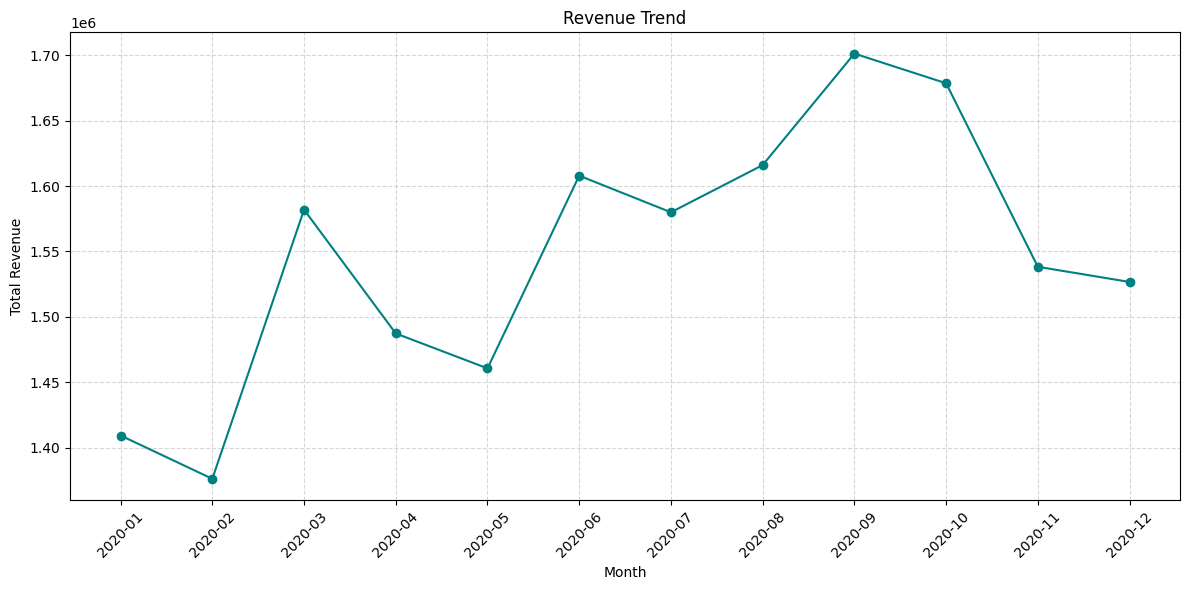

In [11]:
tempTran_df['Month'] = tempTran_df['Date'].dt.to_period('M').astype(str)
monthly_revenue = tempTran_df.groupby('Month')['Revenue'].sum().reset_index()
monthly_revenue['Month'] = monthly_revenue['Month'].astype(str)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_revenue['Month'], monthly_revenue['Revenue'], marker='o', color='teal')
plt.title('Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

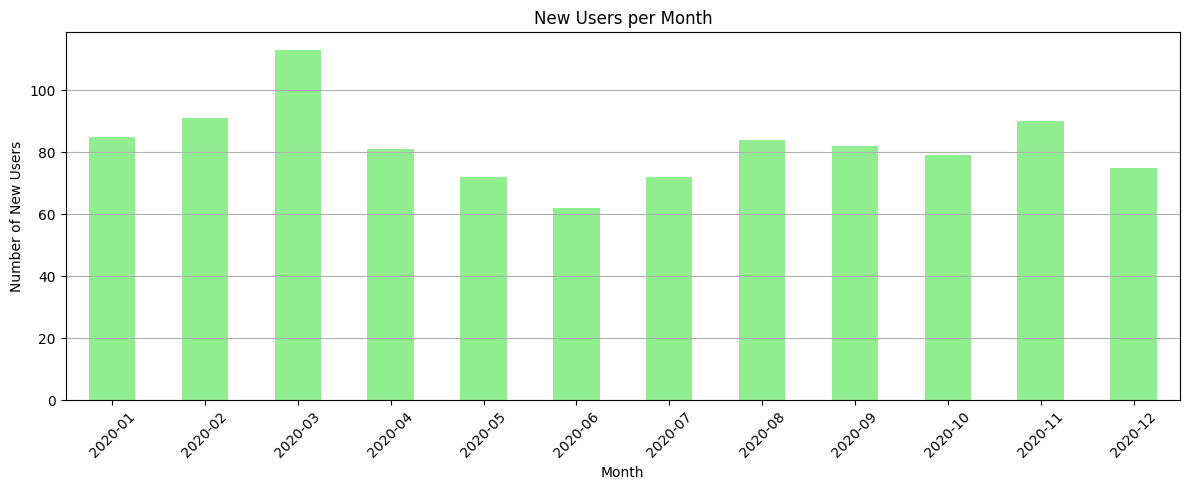

In [12]:
tempTran_df['Month'] = tempTran_df['Date'].dt.to_period('M').astype(str)
new_users = tempTran_df[tempTran_df['Type_user'] == 'New']
new_users_per_month = new_users.groupby('Month')['user_id'].nunique()

new_users_per_month.plot(kind='bar', figsize=(12, 5), color='lightgreen', title='New Users per Month')
plt.ylabel("Number of New Users")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

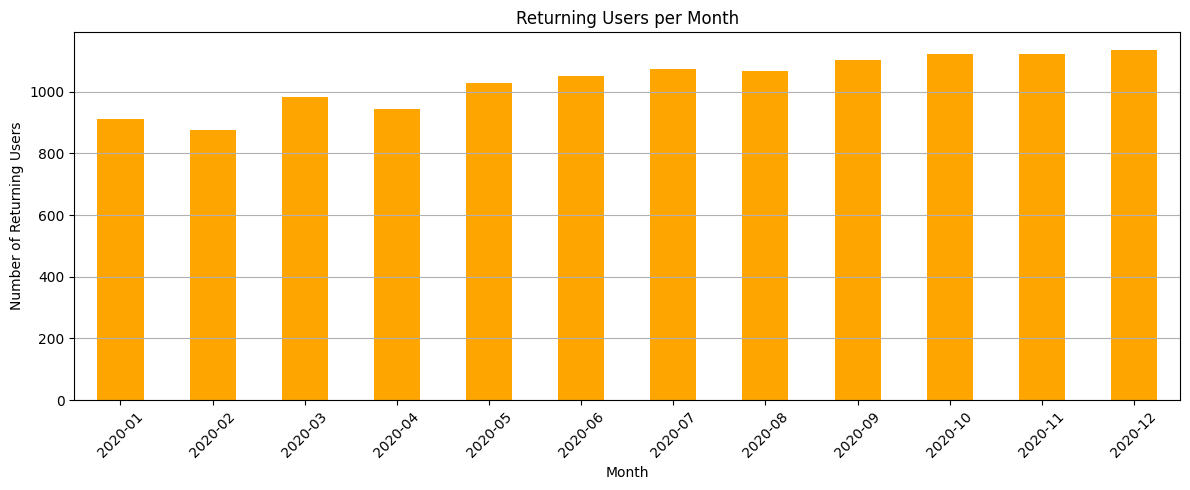

In [13]:
returning_users = tempTran_df[tempTran_df['Type_user'] == 'Current']
returning_users_per_month = returning_users.groupby('Month')['user_id'].nunique()

returning_users_per_month.plot(kind='bar', figsize=(12, 5), color='orange', title='Returning Users per Month')
plt.ylabel("Number of Returning Users")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [14]:
merchant_revenue = tempTran_df.groupby('Merchant_id')['Revenue'].sum().astype(int)
merchant_transactions = tempTran_df.groupby('Merchant_id')['order_id'].count()
merchant_total_amount = tempTran_df.groupby('Merchant_id')['Amount'].sum()

merchant_summary = pd.DataFrame({
    'Revenue': merchant_revenue,
    'Total_Transactions': merchant_transactions,
    'Total_Transaction_Amount': merchant_total_amount
}).reset_index()

# Merge with commission_df
merchant_summary = merchant_summary.merge(commission_df, on='Merchant_id', how='left')
merchant_summary = merchant_summary[['Merchant_name', 'Merchant_id', 'Rate_pct', 'Revenue', 'Total_Transactions', 'Total_Transaction_Amount']]
merchant_summary = merchant_summary.sort_values(by='Revenue', ascending=False)

print("🏆 Top Performing Merchants:")
display(merchant_summary)

🏆 Top Performing Merchants:


,Merchant_name,Merchant_id,Rate_pct,Revenue,Total_Transactions,Total_Transaction_Amount
0,Viettel,12,2,7099200,6743,354960000
1,Mobifone,13,3,5699227,3755,189974234
2,Vinaphone,14,4,4903600,2311,122590000
3,Vietnamobile,15,4,859200,608,21480000
4,Gmobile,16,4,3200,3,80000


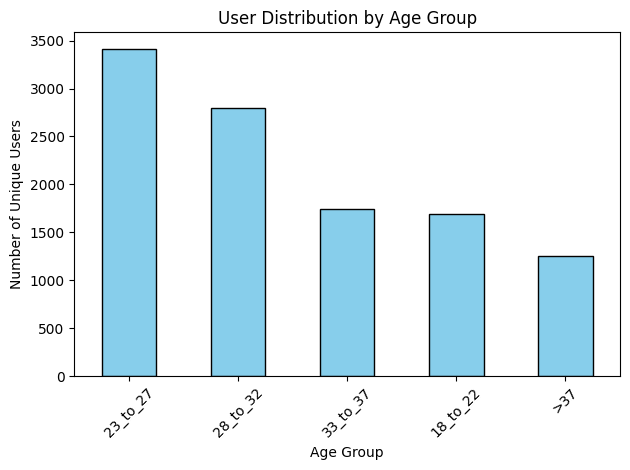

In [15]:
# Count of users by age group
filtered_users_df = users_df[users_df['age'].str.lower() != 'unknown']
age_distribution = filtered_users_df.groupby('age')['user_id'].nunique().sort_values(ascending=False)

# Plot
age_distribution.plot(kind='bar', color='skyblue', edgecolor='black', title='User Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Unique Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


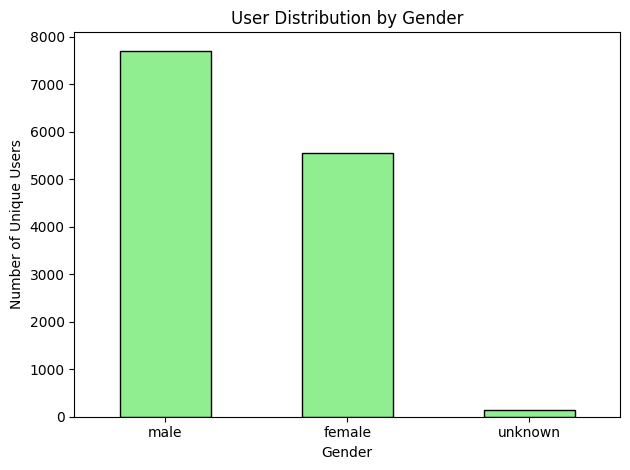

In [16]:
# Count of users by gender
gender_distribution = users_df.groupby('gender')['user_id'].nunique().sort_values(ascending=False)

# Plot
gender_distribution.plot(kind='bar', color='lightgreen', edgecolor='black', title='User Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Unique Users')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


,user_id,order_id,Date,Amount,Merchant_id,Purchase_status,Merchant_rate,Revenue,age,gender,location,Type_user,Month
0,21269588,4169517626,2020-01-01,10000,13,NaN,3.0,300.0,>37,female,HN,Current,2020-01
1,28097592,4170276686,2020-01-01,20000,13,NaN,3.0,600.0,>37,female,HN,Current,2020-01
2,47435144,4166729310,2020-01-01,10000,12,NaN,2.0,200.0,18_to_22,female,HN,Current,2020-01
3,29080935,4174460303,2020-01-01,10000,13,NaN,3.0,300.0,18_to_22,female,HN,Current,2020-01
4,14591075,4168216749,2020-01-01,10000,12,NaN,2.0,200.0,18_to_22,female,Other,Current,2020-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13415,54337200,8720390921,2020-12-31,20000,12,NaN,2.0,400.0,unknown,unknown,Other,Current,2020-12
13416,59931360,8718580146,2020-12-31,100000,12,NaN,2.0,2000.0,unknown,female,Other,Current,2020-12
13417,46156488,8717515352,2020-12-31,20000,12,NaN,2.0,400.0,23_to_27,female,Other,Current,2020-12
13418,35858614,8716668316,2020-12-31,10000,12,NaN,2.0,200.0,28_to_32,female,HN,Current,2020-12


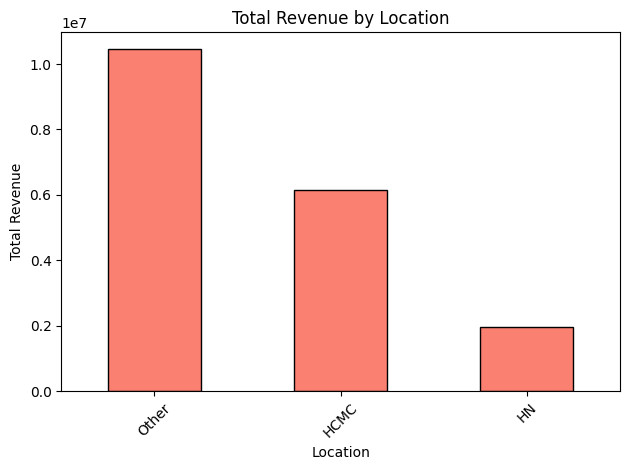

In [17]:
display(tempTran_df)
# Total revenue by location
location_revenue = tempTran_df.groupby('location')['Revenue'].sum().sort_values(ascending=False)

# Plot
location_revenue.plot(kind='bar', color='salmon', edgecolor='black', title='Total Revenue by Location')
plt.xlabel('Location')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


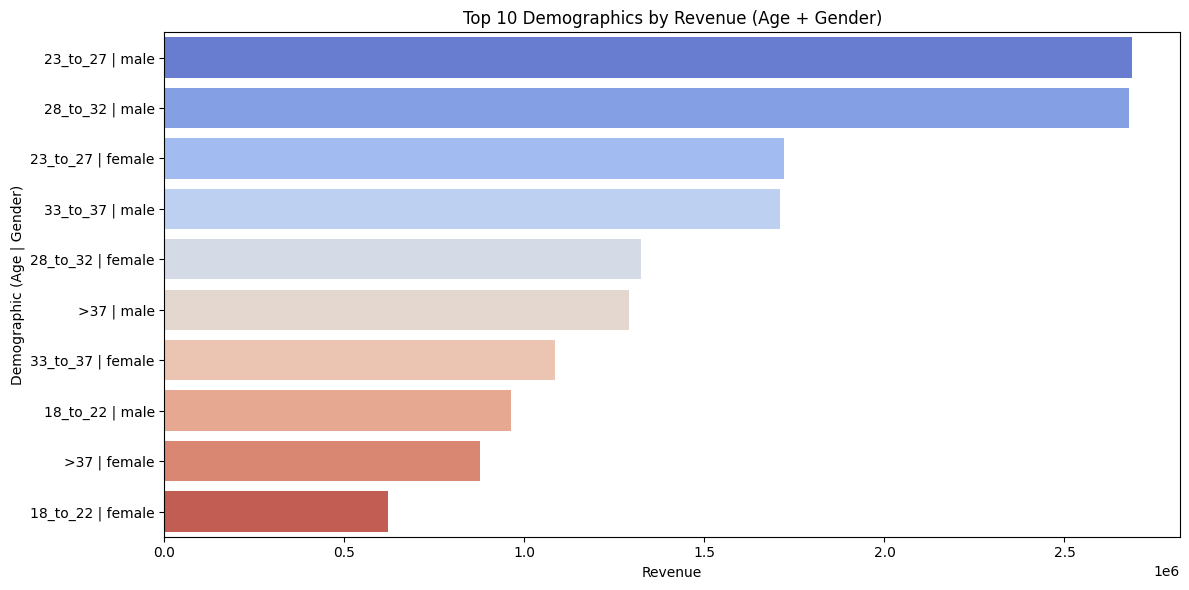

In [18]:

# Filter out unknown age and gender
filtered_df = tempTran_df[(tempTran_df['age'] != 'unknown') & (tempTran_df['gender'] != 'unknown')]

# Group by age and gender, summing revenue
demographic_revenue = filtered_df.groupby(['age', 'gender'])['Revenue'].sum().reset_index()

# Create combined label
demographic_revenue['Demographic'] = demographic_revenue['age'] + ' | ' + demographic_revenue['gender']

# Sort and get top 10
top_demographics = demographic_revenue.sort_values(by='Revenue', ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_demographics,
    x='Revenue',
    y='Demographic',
    hue='Demographic',
    palette='coolwarm',
    dodge=False,
    legend=False
)
plt.title('Top 10 Demographics by Revenue (Age + Gender)')
plt.xlabel('Revenue')
plt.ylabel('Demographic (Age | Gender)')
plt.tight_layout()
plt.show()

In [19]:
monthly_revenue = ndtempTran_df.groupby(tempTran_df['Date'].dt.to_period('M'))['Revenue'].sum().sort_index()

monthly_revenue

Date
2020-01    1409027.02
2020-02    1372900.00
2020-03    1580900.00
2020-04    1485600.00
2020-05    1472300.00
2020-06    1602800.00
2020-07    1562400.00
2020-08    1623200.00
2020-09    1708900.00
2020-10    1691100.00
2020-11    1537800.00
2020-12    1567500.00
Freq: M, Name: Revenue, dtype: float64

# Insights on User Demographics and Transaction Behavior (MoMo Top-Up Data)

---

## 1. Transaction Trends Over Time

**Monthly Revenue Growth**:  Revenue steadily increased throughout the year, peaking in **September (₫1.71 million)**.  
 
  Possibly due to
  - **Seasonal cycles**, like back-to-school (August-September).
  - Higher user engagement after mid-year (e.g., June to Sept).


**Weekly Revenue Patterns**:
  - **Most profitable day**: Wednesday (₫3,064,400)
  - **Least profitable day**: Sunday (₫2,313,927)

---

## 2. User Demographics

**Age Group Distribution**:
  - Top segments: **23–27**, followed closely by **28–32**
  - Smaller segments: **18–22**, **33–37**
  - Lowest segment: **Above 37**

**Gender Split**:
  - Slightly **more male users** than female.

---

## 3. Location Behavior

Users mostly come from **HCMC (Ho Chi Minh City)**
and
Hanoi has a lot less user base

---

## 4. Merchant Preferences

**Top Merchants by Revenue and Usage**:
  1. **Viettel**
  2. **Mobifone**
  3. **Vinaphone**

Underperformers:
  - **Vietnamobile**
  - **Gmobile**

---

## 5. User Behavior & Retention

- **New User Acquisition and Return Rates** are stable.
- No drastic monthly changes in new or returning users.

---

| Category              | Key Insight                                           |
|-----------------------|-------------------------------------------------------|
| Time Trends           | Strong midweek (esp. Wed), weak on Sundays            |
| Demographics          | Dominated by users aged 23–32, more male than female  |
| Merchant Preference   | Viettel, Mobifone, and Vinaphone lead in usage        |
| Location Behavior     | A lot more users in HCM than HN                       |

---


# Marketing Recommendations to Boost MoMo Top-Up Performance

---

## 1. Time-Based Promotions

**Findings:**
Revenue tends to dips on **Sundays**.

**Recommendations:**  
- launch **Weekend Bonuses** to boost sales during **Weekends**

---

## 2. Target High-Converting Demographics

**Findings:**  
- Top age groups are **23–27**, followed by **28–32** and **male** than female users  

**Recommendations:**  
- Offer discounts on **entertainment**, **gaming**, or **student bundles** to boost more sales for users aged 23–32. 

---

## 3. Merchant Partnership Promotions

**Findings:**  
- Top merchants **Viettel**, **Mobifone**, **Vinaphone**  
- Underperformers: **Gmobile**, **Vietnamobile**

**Recommendations:**  
- **Partner with top merchants** for co-branded deals and offer special promos for low-engagement merchants.

---

## 4. Location-Based Strategy

**Findings:**  
- **Ho Chi Minh City (HCMC)** has a significantly larger user base compared to **Hanoi (HN)**.

**Recommendations:**  
- Launch targeted promotions or ad campaigns in **Hanoi** to increase engagement and balance regional performance.
- offers such as **HN-exclusive vouchers** or **regional discount codes** can attract activity from that area.

---

## 5. Monthly Performance Boost

**Insight:**  
- Revenue gets higher after **May** until **September, October** which could be due to **out of school season**.
- But gets **lower** during **school seasons**.

<img src="Screenshot 2025-06-27 132037.png" width="1000" height="1000">

**Recommendations:**  
- Run **School Related** bundles After **September** to boost sales during school opening months
- Offer **holiday-themed promotions**  during summer to boost even more sales in out of school months.

---

## 6. Retention Focus
 
- **Loyalty Rewards**: Monthly streak bonuses like  
  _“Top up 3 months in a row → ₫50,000 cashback.”_  
- Use in-app reminders for users inactive for over 30 days.

---

## 8. MoMo's Proposed Cashback Increase – Evaluation

### Proposed Cashback Changes

| Merchant       | Current Cashback (%) | Proposed Cashback (%) |
|----------------|----------------------|------------------------|
| Viettel        | 1.0                  | 2.0                    |
| Mobifone       | 1.0                  | 2.5                    |
| Vinaphone      | 1.0                  | 3.0                    |
| Vietnamobile   | 1.0                  | 3.0                    |
| Gmobile        | 1.0                  | 3.0                    |

---

### Evaluation from multiple perspective

#### Customer Perspective
- Impact: Higher Cashback is more attractive to users.. Users will be encouraged to use MoMo to top-up.

#### MoMo’s Revenue
- Revenue per transaction will reduce due to higher cashback payouts but Higher engagement could increase transaction volume ultimately resulting in more revenue.
- 
#### Market Competition
- Strong move to compete with aggressive cashback strategies from rival e-wallets but could trigger a "cashback war" and putting margin pressure across the industry.

#### Merchant Dynamics
- Top merchants (Viettel, Mobifone, Vinaphone) already dominate. Increased cashback here reinforces user loyalty.
- Offering higher cashback for smaller telcos can help MoMo capture a larger share of their user base and become the No.1 top-up platform for those networks.

---

### In conclusion
We agree with this proposal but with some conditions:
- Implement as a limited-time campaign first, to monitor user response.
- Use cashback strategically, e.g., higher cashback for weekends, underperforming months, or new users.

---

## 9. Additional Development Strategies for MoMo Top-Up

### 1. Gamified Top-Up Challenges
- Since Most user demographic shows a lot of young male.
- Rewards with small cashback, spins, or vouchers to boost engagement and repeat usage.

### 2. Referral-Based Rewards
- “Invite 2 friends to top up this month → receive 50,000 VND bonus.”
- Encourages new user growth.

### 4. Smart Data Packs
- Create bundles combining telco top-up with MoMo services.
- Cross-sell MoMo’s other features to increase wallet stickiness.

### 5. Student Packages
- Partner with universities or student unions to create special top-up packs.
- Targets MoMo's most active age segment (18–32).
